<a href="https://colab.research.google.com/github/Farii01/Detectron2_Work/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [118]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7z6phaz3
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7z6phaz3
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [119]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


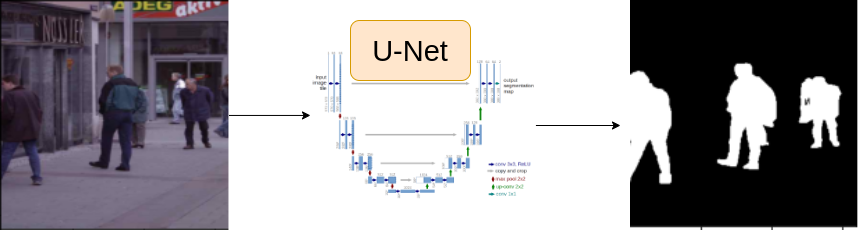

# Some Common Imports

In [120]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [121]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [122]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 10
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'resnet34'
WEIGHTS = 'imagenet'

In [123]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [124]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image =cv2.imread(image_path)
image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

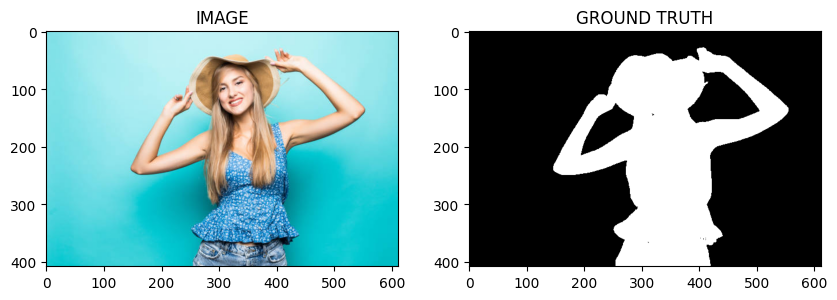

In [125]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [126]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state =42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [127]:
import albumentations as a

In [128]:
def get_train_augs():
    return a.Compose([
        a.Resize(IMG_SIZE, IMG_SIZE),
        a.HorizontalFlip(p=0.5),
        a.VerticalFlip(p=0.5)
    ], additional_targets={'mask': 'image'})

def get_valid_augs():
    return a.Compose([
        a.Resize(IMG_SIZE, IMG_SIZE)
    ], additional_targets={'mask': 'image'})



# Task 4 : Create Custom Dataset

In [129]:
from torch.utils.data import Dataset

In [130]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and resize the mask to match the image dimensions
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

            # h,w,c -> c h w
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

            # convert to tensor from numpy
            image = torch.Tensor(image) / 255.0
            mask = torch.round(torch.Tensor(mask) / 255.0)

            return image, mask


In [131]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [132]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [133]:
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)


Image shape: (408, 612, 3)
Mask shape: (408, 612)


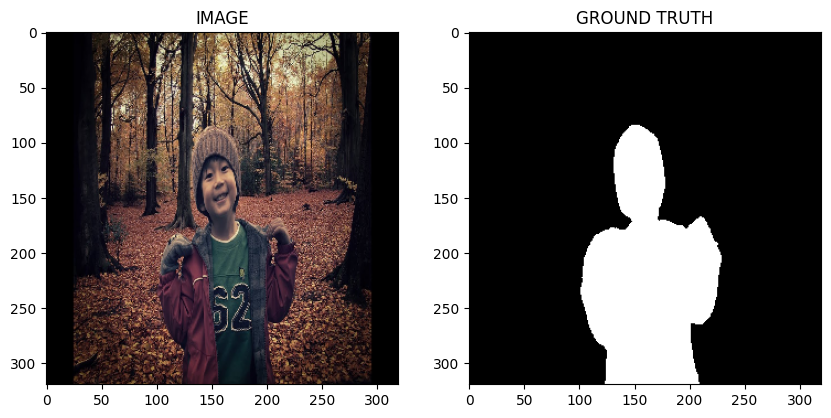

In [134]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)


# Task 5 : Load dataset into batches

In [135]:
from torch.utils.data import DataLoader

In [136]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle = True)

In [137]:
print(f"total no. od batches in trainloader : {len(trainloader)}")
print(f"total no. od batches in validloader : {len(validloader)}")

total no. od batches in trainloader : 15
total no. od batches in validloader : 4


In [138]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch image shape : {mask.shape}")


One batch image shape : torch.Size([16, 3, 320, 320])
One batch image shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [139]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [140]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            # Calculate Dice Loss
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)

            return logits, loss1 + loss2

        return logits



In [141]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [142]:
import torch.nn as nn

def calculate_loss(logits, masks, loss_weight1=1.0, loss_weight2=1.0):
    """
    Calculate the combined loss given logits and ground truth masks.

    Args:
        logits (torch.Tensor): Model's predictions (logits).
        masks (torch.Tensor): Ground truth masks.
        loss_weight1 (float): Weight for the first loss component (e.g., Dice Loss).
        loss_weight2 (float): Weight for the second loss component (e.g., BCE Loss).

    Returns:
        torch.Tensor: Combined loss.
    """
    # Calculate Dice Loss (or other loss)
    loss1 = DiceLoss(mode='binary')(logits, masks)

    # Calculate BCE Loss (or other loss)
    loss2 = nn.BCEWithLogitsLoss()(logits, masks)

    # Combine the losses with specified weights
    combined_loss = loss_weight1 * loss1 + loss_weight2 * loss2

    return combined_loss


# Task 7 : Create Train and Validation Function

In [143]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)  # Remove masks as input, as they are not needed during training
        loss = calculate_loss(logits, masks)  # Calculate the loss separately
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


In [144]:
import torch
import torch.nn.functional as F

def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)




# Task 8 : Train Model

In [145]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [146]:
model = SegmentationModel()


In [147]:
import torch
torch.cuda.is_available()


True

In [148]:
# Move your model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


SAVED-MODEL
Epoch : 1 Train loss: 1.3349383354187012 Valid loss : 1.3664210438728333


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 2 Train loss: 1.3327232678731282 Valid loss : 1.3692063093185425


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


SAVED-MODEL
Epoch : 3 Train loss: 1.3381189982096353 Valid loss : 1.3639080822467804


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


SAVED-MODEL
Epoch : 4 Train loss: 1.3323686440785727 Valid loss : 1.3605162501335144


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch : 5 Train loss: 1.341818912823995 Valid loss : 1.3616773188114166


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 6 Train loss: 1.3361132860183715 Valid loss : 1.3626937866210938


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch : 7 Train loss: 1.3372558196385702 Valid loss : 1.3616155087947845


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Epoch : 8 Train loss: 1.3392810026804607 Valid loss : 1.364649087190628


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 9 Train loss: 1.3335221846898397 Valid loss : 1.364633947610855


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch : 10 Train loss: 1.3370047489802042 Valid loss : 1.364833503961563


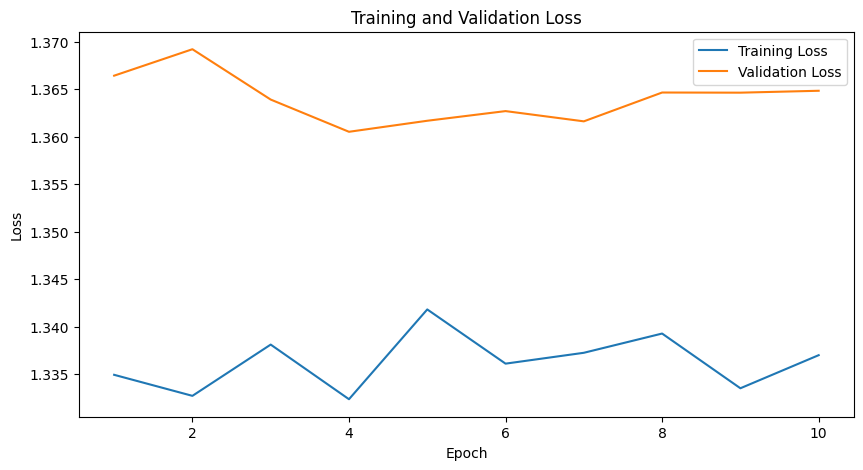

In [154]:
import matplotlib.pyplot as plt

# Lists to store training and validation loss values
train_losses = []
valid_losses = []

best_valid_loss = np.Inf  # Initialize best_valid_loss

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    # Save the loss values
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train loss: {train_loss} Valid loss : {valid_loss}")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Task 9 : Inference

In [155]:
idx = 21

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > .5)*1.0



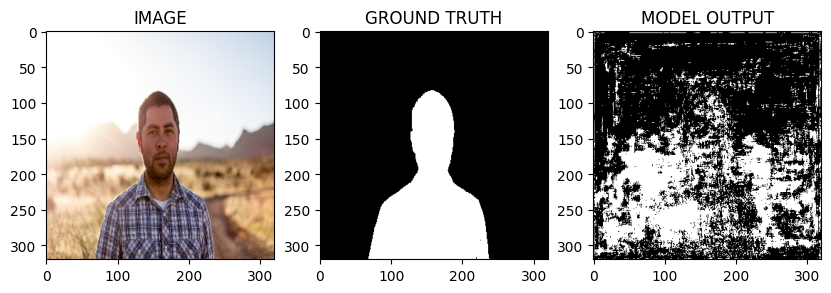

In [156]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya